In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from copy import deepcopy

import scipy
from scipy import special as s
import pandas as pd
import numpy
import math
from time import time
from tqdm import tqdm

/Users/karlhajjar/Documents/projects/deep-wide-resnets/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks.muP_resnet import MuPResNet

# Constants

In [6]:
INPUT_DIM = 64 #30
WIDTH = 256 #512 #512 # 512 #40 # 256
#D_MODEL = 128
N_RES = 500 #1000
BIAS = False
ALPHA = 1.0
SCALE = 1.0
ACTIVATION = 'relu'

SEED = 42
BATCH_SIZE = 64
#N_TRIALS = 10 #10
BASE_LR = 1.0e-2
N_STEPS = int(4.0e3)
N_VAL = 500
VAL_ITER = 50

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/training/')
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

# Data & network

In [9]:
alpha = 1 / N_RES  # alpha scale for the residual connection

# f^* parameters
w_star = torch.rand(size=(INPUT_DIM, 1), requires_grad=False)
y_star = torch.randn(size=(1,), requires_grad=False)

# train data
X_train = torch.randn(size=(N_STEPS, BATCH_SIZE, INPUT_DIM), requires_grad=False)
y_train = 2 * torch.tanh(y_star + torch.matmul(X_train, w_star))**2 

# val data
x_val = torch.randn(size=(N_VAL, INPUT_DIM), requires_grad=False)
y_val = 2 * torch.tanh(y_star + torch.matmul(x_val, w_star))**2

# network & optimizer
net = MuPResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, n_res=N_RES)
opt = torch.optim.SGD(params=net.parameters(), lr=BASE_LR)

### Train nets

In [10]:
# ALPHA = 1/L

train_losses = []
val_losses = []
s = time()
val_iters = []
ratios_train = []
direct_ratios_train = []

s = time()
for t in tqdm(range(N_STEPS)):
    x = X_train[t, : , :]
    y = y_train[t, :, :]
    opt.zero_grad()
    
    # forward pass
    y_hat = net(x)
    loss = 0.5 * torch.mean((y_hat - y) ** 2)
    
    # backward pass
    loss.backward()  # gradient computation
    opt.step()  # parameter update
    train_losses.append(loss.detach().item())
    
    
    if t % VAL_ITER == 0:
        val_iters.append(t+1)
        with torch.no_grad():
            # compute and store ratios
            h_0 = np.sqrt(net.d_model) * net.input_layer(x_val)  # muP scaling for the first layer
            h_L = net.residual_layers(h_0)
            h_0_norm = torch.norm(h_0, dim=1, p=2)
            
            ratios_train.append(torch.mean((torch.norm(h_L - h_0, dim=1,p=2)) /
                                           h_0_norm).detach().item())
            direct_ratios_train.append(torch.mean((torch.norm(h_L, dim=1,p=2)) /
                                                  h_0_norm).detach().item())
            
            # compute and store loss
            y_hat_val = net.output_layer(h_L) / np.sqrt(net.d_model)
            
            #y_hat_val = net(x_val)
            val_loss = 0.5 * torch.mean((y_hat_val - y_val) ** 2).detach().item()
            val_losses.append(val_loss)
        #print('Train loss at step {:,}: {:.5f}'.format(t, loss.detach().item()))
        #print('Val loss at step {:,}: {:.5f}'.format(t, val_loss))

e = time()
print('Time for {:,} iterations with L={:,}, m={:,} : {:.2f} minutes'.format(N_STEPS, N_RES, WIDTH, (e - s)/60))

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

100%|███████████████████████████████████████| 4000/4000 [45:56<00:00,  1.45it/s]

Time for 4,000 iterations with L=500, m=256 : 45.95 minutes


In [11]:
# ALPHA = 1/\sqrt{L}
alpha = 1 / np.sqrt(N_RES)

# network & optimizer
net_g = MuPResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=BIAS, alpha=alpha, n_res=N_RES)
opt_g = torch.optim.SGD(params=net_g.parameters(), lr=BASE_LR)

train_losses_g = []
val_losses_g = []
s = time()
val_iters_g = []
#ratios_train = []
#direct_ratios_train = []

s = time()
for t in tqdm(range(N_STEPS)):
    x = X_train[t, : , :]
    y = y_train[t, :, :]
    opt_g.zero_grad()
    
    # forward pass
    y_hat = net_g(x)
    loss = 0.5 * torch.mean((y_hat - y) ** 2)
    
    # backward pass
    loss.backward()  # gradient computation
    opt_g.step()  # parameter update
    train_losses_g.append(loss.detach().item())
    
    
    if t % VAL_ITER == 0:
        val_iters.append(t+1)
        with torch.no_grad():
            # compute and store loss
            y_hat_val = net_g(x_val)
            
            #y_hat_val = net(x_val)
            val_loss = 0.5 * torch.mean((y_hat_val - y_val) ** 2).detach().item()
            val_losses_g.append(val_loss)
        #print('Train loss at step {:,}: {:.5f}'.format(t, loss.detach().item()))
        #print('Val loss at step {:,}: {:.5f}'.format(t, val_loss))

e = time()
print('Time for {:,} iterations with L={:,}, m={:,} : {:.2f} minutes'.format(N_STEPS, N_RES, WIDTH, (e - s)/60))

train_losses_g = np.array(train_losses_g)
val_losses_g = np.array(val_losses_g)

100%|███████████████████████████████████████| 4000/4000 [43:00<00:00,  1.55it/s]

Time for 4,000 iterations with L=500, m=256 : 43.00 minutes


### Train pure linear

In [12]:
w = torch.nn.Linear(in_features=INPUT_DIM, out_features=1, bias=BIAS)
with torch.no_grad():
    w.weight.data.copy_(torch.zeros_like(w.weight.detach().data))
opt_w = torch.optim.SGD(params=w.parameters(), lr=0.05)
lin_losses = []
lin_val_losses = []
lin_val_iters = []
for t in tqdm(range(2500)):
    x = X_train[t%N_STEPS, : , :]
    y = y_train[t%N_STEPS, :, :]
    opt_w.zero_grad()
    
    # forward pass
    y_hat = w(x)
    loss = 0.5 * torch.mean((y_hat - y) ** 2)
    
    # backward pass
    loss.backward()  # gradient computation
    opt_w.step()  # parameter update
    lin_losses.append(loss.detach().item())
    
    
    if t % VAL_ITER == 0:
        lin_val_iters.append(t+1)
        with torch.no_grad():
            y_hat_val = w(x_val)
            
            #y_hat_val = net(x_val)
            val_loss = 0.5 * torch.mean((y_hat_val - y_val) ** 2).detach().item()
            lin_val_losses.append(val_loss)

100%|█████████████████████████████████████| 2500/2500 [00:00<00:00, 3347.97it/s]


### Train linear over first layer features (h_0)

In [13]:
w_feat = torch.nn.Linear(in_features=net.d_model, out_features=1, bias=BIAS)
#with torch.no_grad():
#    w_feat.weight.data.copy_(torch.zeros_like(w_feat.weight.detach().data))
opt_w_feat = torch.optim.SGD(params=w_feat.parameters(), lr=0.05)
lin_feat_losses = []
lin_feat_val_losses = []
lin_feat_val_iters = []

with torch.no_grad():
    h0_val = np.sqrt(net.d_model) * net.input_layer(x_val)

for t in tqdm(range(5000)):
    x = X_train[t%N_STEPS, : , :]
    y = y_train[t%N_STEPS, :, :]
    with torch.no_grad():
        h0 = np.sqrt(net.d_model) * net.input_layer(x)  # muP scaling for the first layer
    opt_w_feat.zero_grad()
    
    # forward pass
    y_hat = w_feat(h0) / net.d_model
    loss = 0.5 * torch.mean((y_hat - y) ** 2)
    
    # backward pass
    loss.backward()  # gradient computation
    opt_w_feat.step()  # parameter update
    lin_feat_losses.append(loss.detach().item())
    
    
    if t % VAL_ITER == 0:
        lin_feat_val_iters.append(t+1)
        with torch.no_grad():
            y_hat_val = w_feat(h0_val) / net.d_model
            
            #y_hat_val = net(x_val)
            val_loss = 0.5 * torch.mean((y_hat_val - y_val) ** 2).detach().item()
            lin_feat_val_losses.append(val_loss)

100%|█████████████████████████████████████| 5000/5000 [00:02<00:00, 2176.83it/s]


### Train linear over last layer features (h_L)

In [14]:
wL_feat = torch.nn.Linear(in_features=net.d_model, out_features=1, bias=BIAS)
#with torch.no_grad():
#    w_feat.weight.data.copy_(torch.zeros_like(w_feat.weight.detach().data))
opt_wL_feat = torch.optim.SGD(params=wL_feat.parameters(), lr=0.2)
linL_feat_losses = []
linL_feat_val_losses = []
linL_feat_val_iters = []

with torch.no_grad():
    hLs = [net.residual_layers(np.sqrt(net.d_model) * net.input_layer(X_train[t, : , :]))
           for t in tqdm(range(N_STEPS))]
    hLs = torch.stack(hLs)

with torch.no_grad():
    h0_val = np.sqrt(net.d_model) * net.input_layer(x_val)
    hL_val = net.residual_layers(h0_val)

for t in tqdm(range(8000)):
    hL = hLs[t%N_STEPS, :, :]
    opt_wL_feat.zero_grad()
    
    # forward pass
    y_hat = wL_feat(hL) / net.d_model
    loss = 0.5 * torch.mean((y_hat - y) ** 2)
    
    # backward pass
    loss.backward()  # gradient computation
    opt_wL_feat.step()  # parameter update
    linL_feat_losses.append(loss.detach().item())
    
    
    if t % VAL_ITER == 0:
        linL_feat_val_iters.append(t+1)
        with torch.no_grad():
            y_hat_val = wL_feat(hL_val) / net.d_model
            
            #y_hat_val = net(x_val)
            val_loss = 0.5 * torch.mean((y_hat_val - y_val) ** 2).detach().item()
            linL_feat_val_losses.append(val_loss)

100%|█████████████████████████████████████| 8000/8000 [00:02<00:00, 3164.22it/s]


# Plots

## 1. Losses

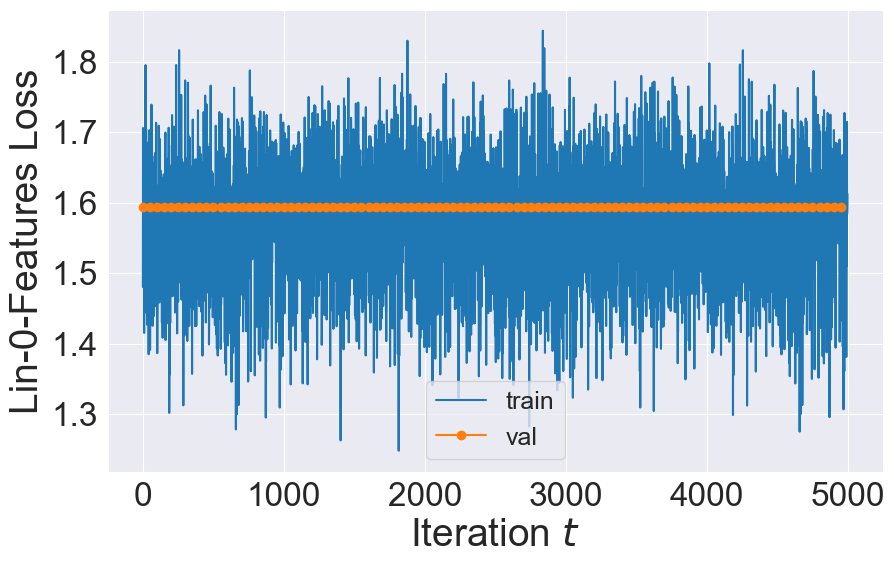

In [50]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
marker = 'o'
#marker = 'o'
#plt.xscale('log')

#T_MAX = 100

#plt.plot(np.arange(N_STEPS), train_losses, label='train')
plt.plot(np.arange(len(lin_feat_losses)), lin_feat_losses, label='train')
#plt.plot(np.arange(start=0, stop=N_STEPS, step=VAL_ITER), val_losses, label='val')
plt.plot(lin_feat_val_iters, lin_feat_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Lin-0-Features Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'lin_0_loss.png'), bbox_inches='tight')
plt.show()

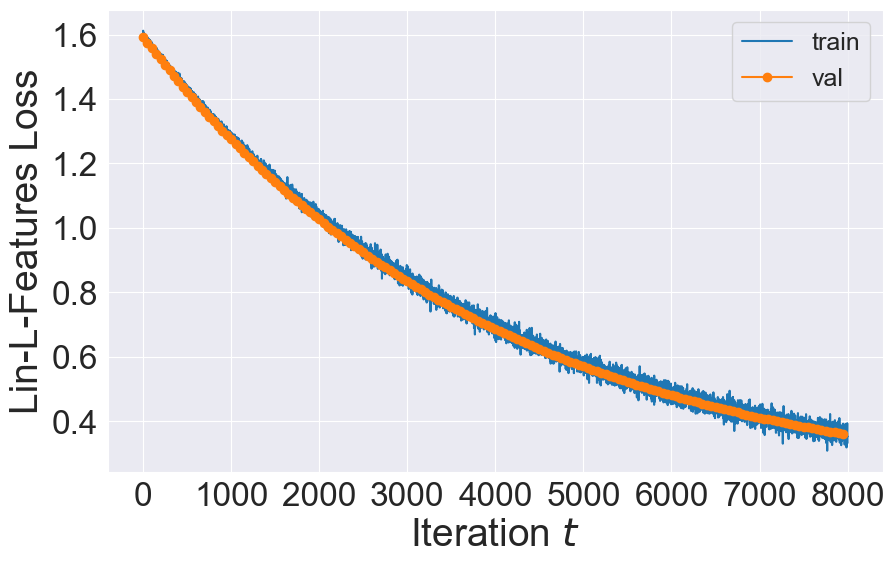

In [51]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
marker = 'o'
#marker = 'o'
#plt.xscale('log')

#T_MAX = 100

#plt.plot(np.arange(N_STEPS), train_losses, label='train')
plt.plot(np.arange(len(linL_feat_losses)), linL_feat_losses, label='train')
#plt.plot(np.arange(start=0, stop=N_STEPS, step=VAL_ITER), val_losses, label='val')
plt.plot(linL_feat_val_iters, linL_feat_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Lin-L-Features Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'lin_L_loss.png'), bbox_inches='tight')
plt.show()

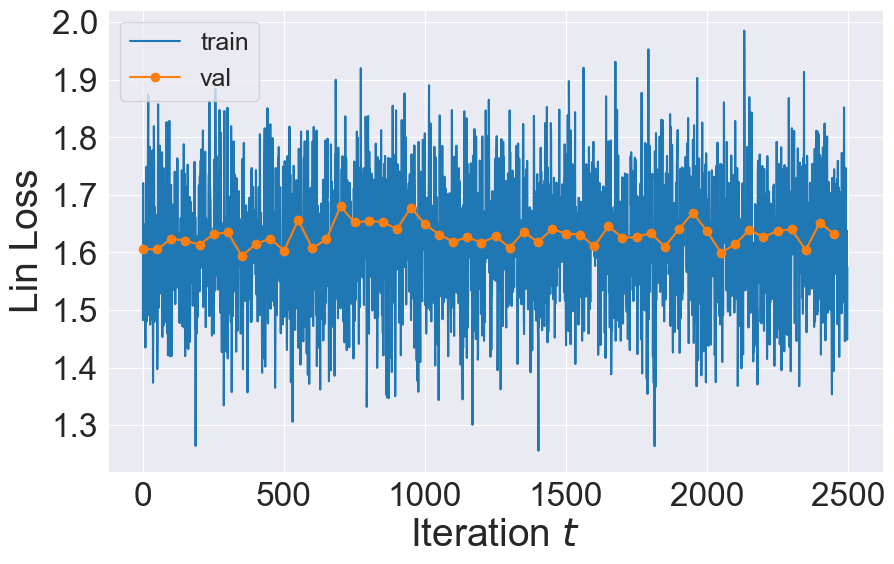

In [52]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
marker = 'o'
#marker = 'o'
#plt.xscale('log')

#T_MAX = 100

#plt.plot(np.arange(N_STEPS), train_losses, label='train')
plt.plot(np.arange(len(lin_losses)), lin_losses, label='train')
#plt.plot(np.arange(start=0, stop=N_STEPS, step=VAL_ITER), val_losses, label='val')
plt.plot(lin_val_iters, lin_val_losses, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Lin Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'pure_lin.png'), bbox_inches='tight')
plt.show()

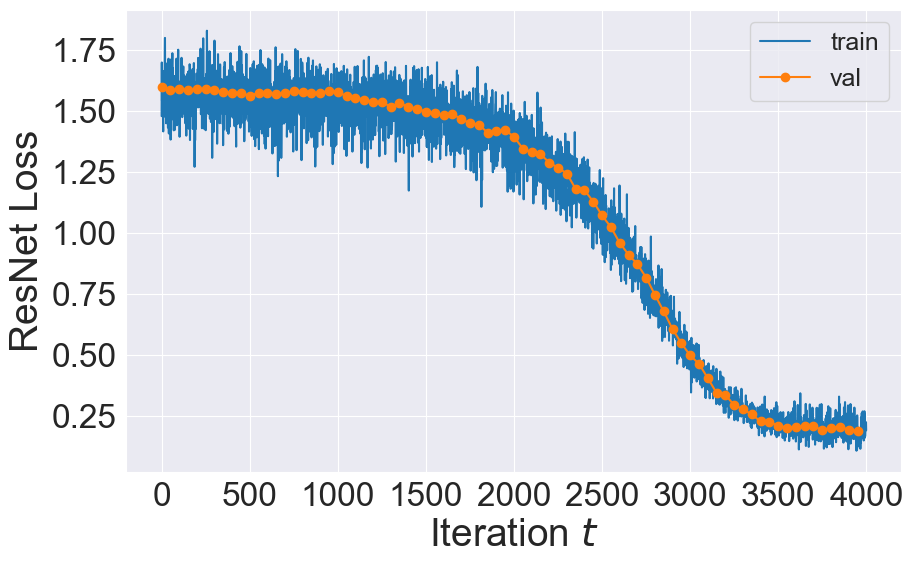

In [53]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
marker = 'o'
#marker = 'o'
#plt.xscale('log')

#T_MAX = 100

#plt.plot(np.arange(N_STEPS), train_losses, label='train')
plt.plot(np.arange(len(train_losses)), train_losses, label='train')
#plt.plot(np.arange(start=0, stop=N_STEPS, step=VAL_ITER), val_losses, label='val')
plt.plot(np.arange(start=0, stop=len(train_losses), step=VAL_ITER), val_losses, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('ResNet Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'resnet_loss.png'), bbox_inches='tight')
plt.show()

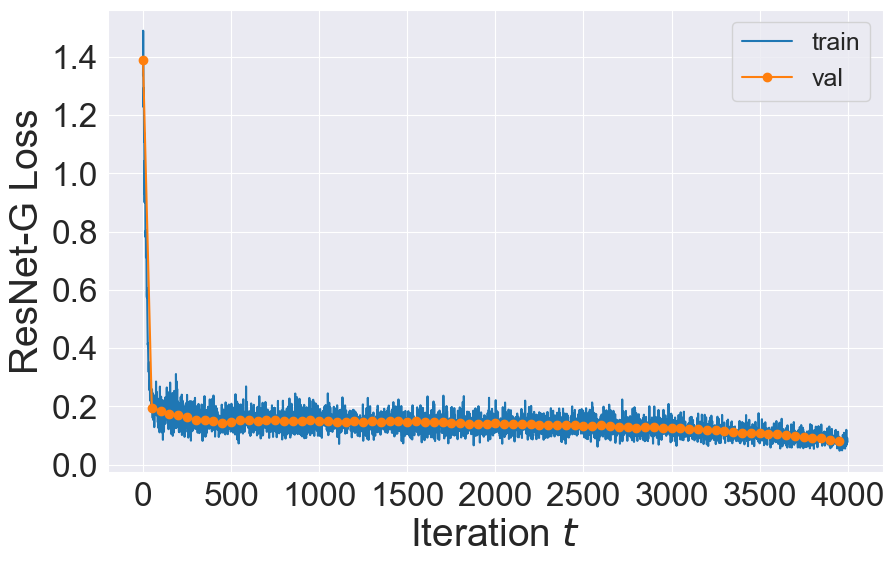

In [54]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
marker = 'o'
#marker = 'o'
#plt.xscale('log')

#T_MAX = 100

#plt.plot(np.arange(N_STEPS), train_losses, label='train')
plt.plot(np.arange(len(train_losses_g)), train_losses_g, label='train')
#plt.plot(np.arange(start=0, stop=N_STEPS, step=VAL_ITER), val_losses, label='val')
#plt.plot(val_iters, val_losses_g, label='val', marker=marker)
plt.plot(np.arange(start=0, stop=len(train_losses_g), step=VAL_ITER), val_losses_g, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('ResNet-G Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'resnet_G_loss.png'), bbox_inches='tight')
plt.show()

## 2. Ratios

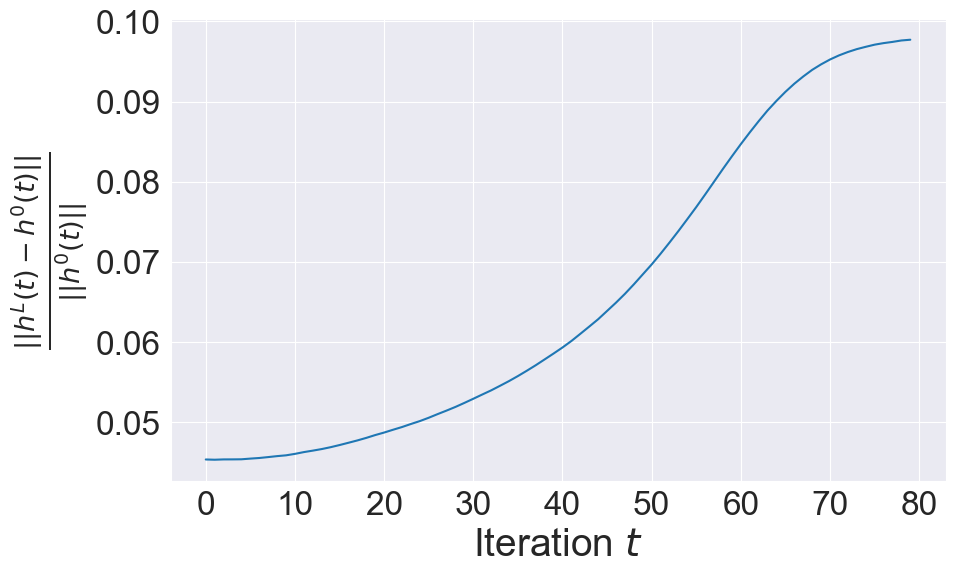

In [21]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
#plt.xscale('log')

#T_MAX = 100

#plt.plot(np.arange(N_STEPS), train_losses, label='train')
plt.plot(np.arange(len(ratios_train)), ratios_train)
#plt.plot(np.arange(start=0, stop=N_STEPS, step=VAL_ITER), val_losses, label='val')
#plt.plot(val_iters, val_losses, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
#plt.ylabel('$||h^L(t) - h^0(t)|| \, / ||h^0(t)||$', fontsize=28)
plt.ylabel('$\\frac{||h^L(t) - h^0(t)||}{||h^0(t)||}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

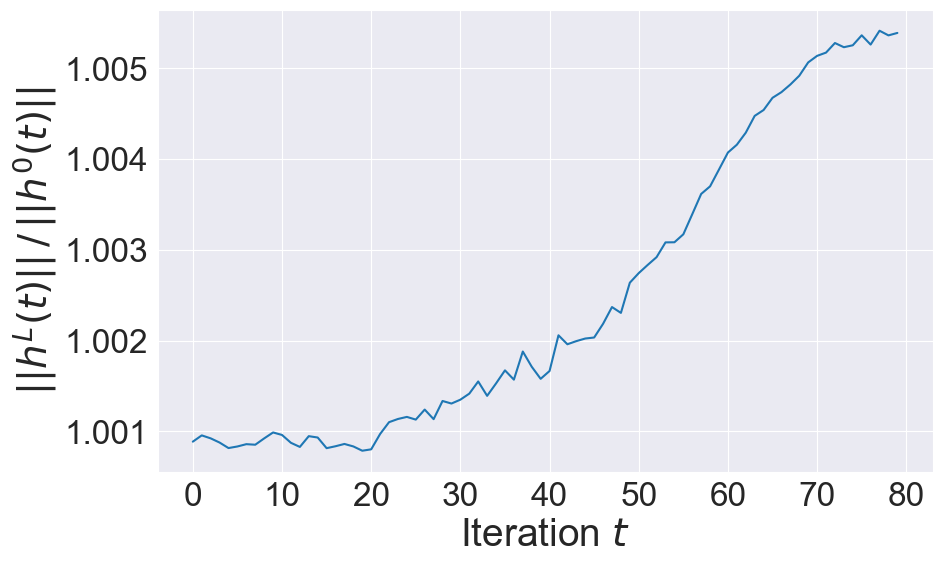

In [22]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
#plt.xscale('log')

#T_MAX = 100

#plt.plot(np.arange(N_STEPS), train_losses, label='train')
plt.plot(np.arange(len(ratios_train)), direct_ratios_train)
#plt.plot(np.arange(start=0, stop=N_STEPS, step=VAL_ITER), val_losses, label='val')
#plt.plot(val_iters, val_losses, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
#plt.ylabel('$||h^L(t) - h^0(t)|| \, / ||h^0(t)||$', fontsize=28)
plt.ylabel('$||h^L(t)|| \, / \, ||h^0(t)||}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

## Norms ratio after training

In [23]:
ratios = dict()
direct_ratios = dict()
#grad_ratios = dict()
#direct_grad_ratios = dict()

with torch.no_grad():
    h = np.sqrt(net.d_model) * net.input_layer(x)  # muP scaling for the first layer
    h_0 = deepcopy(h.detach())
    h_0_norm = torch.norm(h, dim=1, p=2)
    h_L = net.residual_layers(h)
    #h_0.retain_grad()
    for l in range(N_RES):
        layer = net.residual_layers[l]
        h = layer(h)
        ratios[l+1] = torch.mean(torch.norm(h - h_0, dim=1, p=2) / h_0_norm).item()
        direct_ratios = torch.mean(torch.norm(h, dim=1, p=2) / h_0_norm).item()
    
    torch.testing.assert_close(h, h_L, rtol=1e-4, atol=1e-4)
    #h_L.retain_grad()

    #y_hat = net.output_layer(h_L) / np.sqrt(net.d_model)  # muP scaling for the last layer
    #loss = 0.5 * torch.mean((y_hat - y)**2)
    #loss.backward()  # gradient computation

    # forward norms

    # backward (grads) norms
    #dh_L_norm = torch.norm(h_L.grad, dim=1, p=2)
    #grad_ratios_[n_res].append(torch.mean((torch.norm(h_0.grad - h_L.grad, dim=1,p=2)) /
    #                           dh_L_norm).detach().item())
    #direct_grad_ratios_[n_res].append(torch.mean((torch.norm(h_0.grad, dim=1,p=2)) / 
    #                                             dh_L_norm).detach().item())

    #grad_ratios[beta] = grad_ratios_
    #direct_grad_ratios[beta] = direct_grad_ratios_

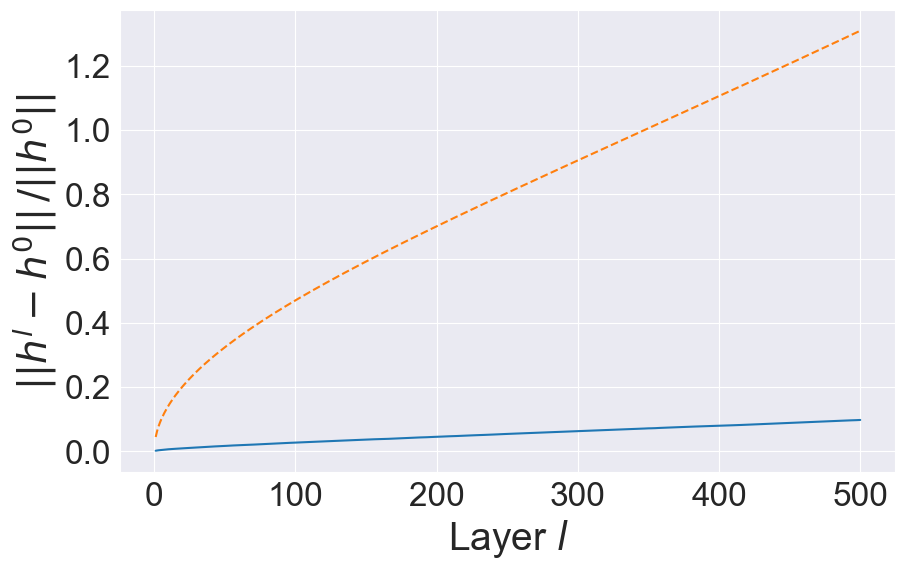

In [24]:
plt.figure(figsize=(10, 6))
#plt.yscale('log')
marker = None
#plt.xscale('log')
colors = sns.color_palette()

plt.plot(np.arange(1, N_RES+1), [ratios[l+1] for l in range(N_RES)], marker=marker)
plt.plot(np.arange(1, N_RES+1), [np.sqrt((1 + alpha**2)**l - 1) for l in range(1, N_RES+1)], linestyle='dashed')

plt.xlabel('Layer $l$', fontsize=28)
plt.ylabel('$||h^l - h^0|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()

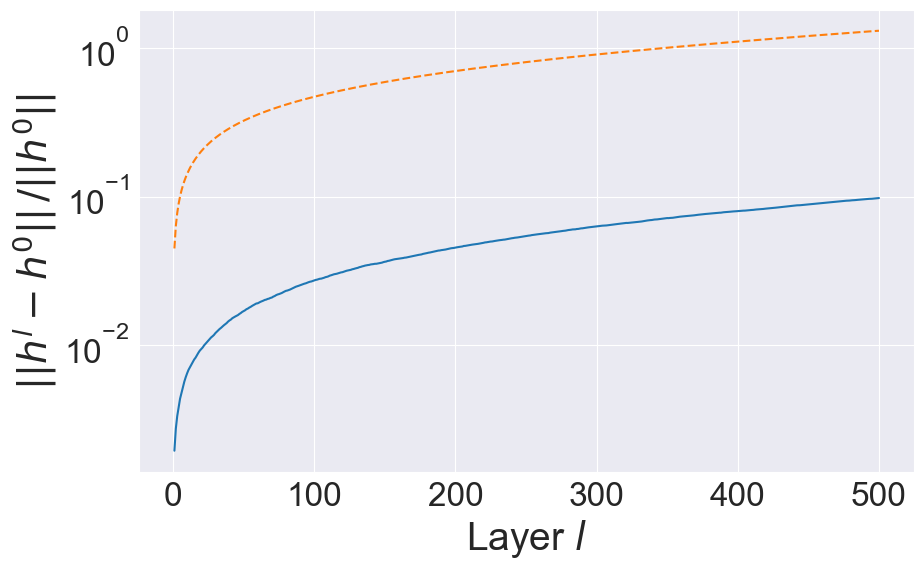

In [25]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
marker = None
#plt.xscale('log')
colors = sns.color_palette()

plt.plot(np.arange(1, N_RES+1), [ratios[l+1] for l in range(N_RES)], marker=marker)
plt.plot(np.arange(1, N_RES+1), [np.sqrt((1 + alpha**2)**l - 1) for l in range(1, N_RES+1)], linestyle='dashed')

plt.xlabel('Layer $l$', fontsize=28)
plt.ylabel('$||h^l - h^0|| \, / ||h^0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'ratio.png'), bbox_inches='tight')
plt.show()